# SBI example for coverage tests - MultiPIT vs. HPD and WALDO

We here try to understand and apply the resuts from [Massearno et al (2022)] on a 2D Gaussian SBI toy example.

We also apply (local)coverage tests (multi-PIT) for validation of the posteriors and compare the results for a good and bad estimator to motivate the necessity of local diagnostics to validate the posterior at the location we wish to infer the CR at, as its validity or at least statistical power depends on it.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.close("all")

import torch
from tqdm import tqdm
import os

from sbi.utils import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal

from tasks.toy_examples.data_generators import SBIGaussian2d
from tasks.toy_examples.embeddings import first_dim_only
from plot import plot_2d_pdf_on_grid, plot_2d_pdf_contours

from nde.flows import construct_maf
from nde.train import train_nflows

from valdiags.graphical_valdiags import multi_cde_pit_values, PP_plot_1D
from valdiags.localPIT_regression import localPIT_regression_baseline
from valdiags.waldo_CRs import (
    hpd_region,
    waldo_confidence_region,
    waldo_stats,
    train_qr_algo
)


In [3]:
B = 100_000
B_PRIME = 10000
B_DOUBLE_PRIME = 10000
N_SAMPLES_POSTERIOR = 50000

PATH_EXPERIMENT = "../saved_experiments/SBIGaussian2d/"

CONFIDENCE_LEVEL = 0.95


## SBI Task: Simulator, Prior and True/Target Posterior 

- Prior (2D): $p(\theta) = \mathcal{U}([-10,10]^2)$
- Simualtor (2D): $x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) = \mathcal{N}(\theta, \Sigma)$ with $\Sigma = \begin{pmatrix} 1 & 0.8 \\ 0.8 & 1 \end{pmatrix}$

Goal: estimate $p(\theta\mid x_0)$ with $x_0$ an observation.

In [4]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior

# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

# Data Generator
data_gen = SBIGaussian2d(prior=prior)

# Simulator
simulator = data_gen.simulator

In [5]:
# Observation
filename = PATH_EXPERIMENT + "groundtruth_observation.pkl"
if os.path.exists(filename):
    observation = torch.load(filename)
    theta_true, x_obs = observation["theta_true"], observation["x_obs"]
else:
    theta_true = torch.FloatTensor([1, 1])  # true parameters
    x_obs = simulator(theta_true)  # x_0 ~ simulator(theta_true)
    observation = {"theta_true": theta_true, "x_obs": x_obs}
    torch.save(observation, "groundtruth_observation.pkl")

# True posterior: P(theta|x_0)
true_posterior_pdf = data_gen.true_posterior_pdf(x_obs)


/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


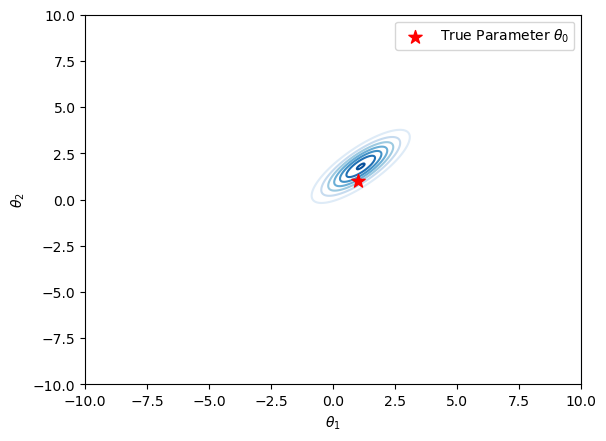

In [6]:
# Plot P(theta|x_0), x_0 ~ simulator(theta_true)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_pdf, low_, high_)
plt.legend()
plt.show()


The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs` and not $\theta_0$=`theta_true`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)/p(x_0) = p(x_0\mid \theta)$ because $p(\theta) \sim \mathcal{U}(0,1)$ is uniform. Finally we have that $p(\theta \mid x_0) = p(x_0\mid \theta) =p_{\mathcal{N}(\theta, \Sigma)}(x_0) = p_{\mathcal{N}(x_0, \Sigma)}(\theta) = \mathcal{N}(x_0, \Sigma)$ because of the symmetry of the gaussian distribution.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation simulated using the true parameter $\theta_0$ to get an empirical approximation of the mean of the simulator likelihood:
$$x_i \sim p(x\mid \theta_0) = \mathcal{N}(\theta_0,\Sigma) \rightarrow x_{mean} = \frac{1}{n}\sum x_i \approx \theta_0$$

So $p(\theta \mid x_{mean}) \approx p(\theta \mid \theta_0) =\mathcal{N}(\theta_0, \Sigma)$.



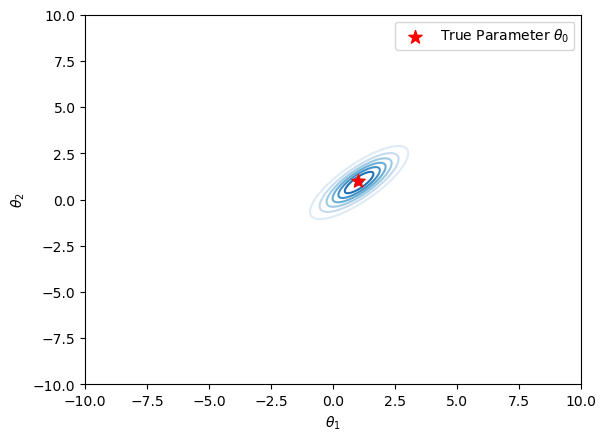

In [7]:
# Plot p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
theta_true = observation['theta_true']
x_obs_100 = torch.stack([simulator(theta_true) for i in range(100)])
true_posterior_100_pdf = data_gen.true_posterior_pdf(x_obs_100)
plt.scatter(theta_true[0], theta_true[1], marker="*", color="red", s=100, zorder=1, label=r'True Parameter $\theta_0$')
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plot_2d_pdf_on_grid(true_posterior_100_pdf, low_, high_)
plt.legend()
plt.show()

## Posterior Estimation: good vs. bad MAF

### Data Generation

In [8]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT+'datasets_big.pkl'

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = data_gen.get_joint_data(B_PRIME)
    b_double_prime_theta, b_double_prime_x = data_gen.get_joint_data(B_DOUBLE_PRIME)

    datasets = {
        "B": {'theta':b_theta, 'x':b_x},
        "B_prime": {'theta':b_prime_theta, 'x':b_prime_x},
        "B_double_prime": {'theta':b_double_prime_theta, 'x':b_double_prime_x},
    }
    torch.save(datasets, filename)


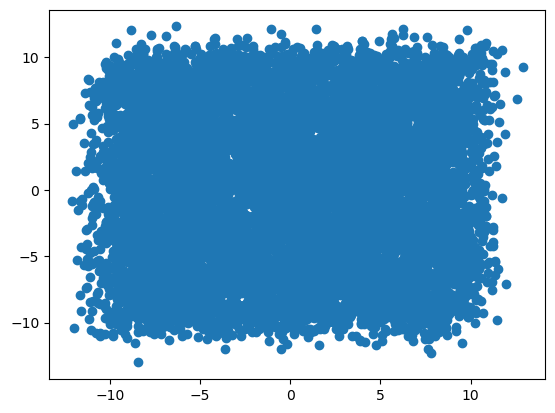

In [9]:
# Simulations Covered Space 
plt.scatter(datasets['B_prime']['x'][:,0], datasets['B_prime']['x'][:,1])
plt.show()

### Train Estimators: NPE (MAF)
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$

In [10]:
# TRAIN/ LOAD TRAINED FLOWS
# Good MAF trained on X=(X_1,X_2)
filename_good = PATH_EXPERIMENT+'maf_good_bigDataset.pkl'

if os.path.exists(filename_good):
    # load flow 
    maf_good = torch.load(filename_good)
else: 
    # define flow
    maf_good = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=2, standardize_transform=False
    )
    # train flow
    best_val_loss_good, epochs_good = train_nflows(
        maf_good,
        datasets['B']['theta'], # Theta
        context=datasets['B']['x'],  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_good, filename_good)

# Bad MAF trained on g(X) = X_1
filename_bad = PATH_EXPERIMENT+'maf_bad_bigDataset.pkl'

if os.path.exists(filename_bad):
    # load flow
    maf_bad = torch.load(filename_bad)
else: 
    # define flow 
    maf_bad = construct_maf(
        datasets['B']['theta'], hidden_features=50, context_features=1, standardize_transform=False
    )
    # train flow
    best_val_loss_bad, epochs_bad = train_nflows(
        maf_bad,
        datasets['B']['theta'], # Theta
        context=first_dim_only(datasets['B']['x']),  # g(X) = X_1
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

    # save flow
    torch.save(maf_bad, filename_bad)


### Plot densities

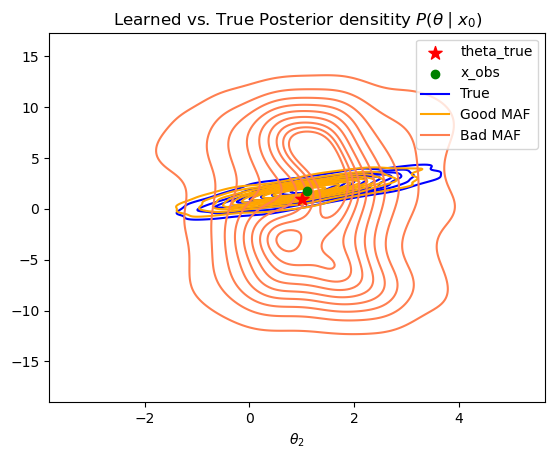

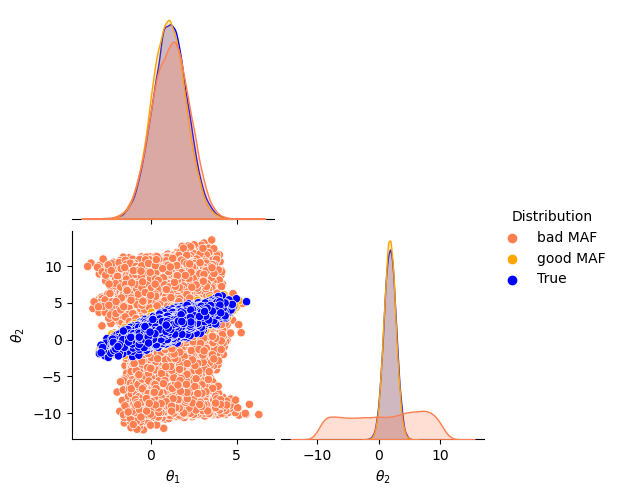

In [12]:
# Plot True vs. learned posteriors: P(theta | x_obs)
true_posterior = data_gen.true_posterior(x_obs)

flows = {
    "Good MAF": (maf_good, x_obs[:][None], "orange"),
    "Bad MAF": (maf_bad, first_dim_only(x_obs[:][None]), "coral"),
}

plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    s=100,
    color="red",
    label="theta_true",
    zorder=3,
)
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plot_2d_pdf_contours(
    true_posterior,
    flows=flows,
    title=r"Learned vs. True Posterior densitity $P(\theta\mid x_0)$",
)

# Pairplot
import pandas as pd
import seaborn as sns
columns = [r"$\theta_1$", r"$\theta_2$"]

samples_true = true_posterior.sample((N_SAMPLES_POSTERIOR,)).numpy()
df_true = pd.DataFrame(samples_true, columns=columns)
df_true["Distribution"] = "True"

maf_samples_good = maf_good.sample(N_SAMPLES_POSTERIOR, context=x_obs[:][None])[0]
df_maf_good = pd.DataFrame(maf_samples_good.detach().numpy(), columns=columns)
df_maf_good["Distribution"] = "good MAF"

maf_samples_bad = maf_bad.sample(N_SAMPLES_POSTERIOR, context=first_dim_only(x_obs[:][None]))[0]
df_maf_bad = pd.DataFrame(maf_samples_bad.detach().numpy(), columns=columns)
df_maf_bad["Distribution"] = "bad MAF"

dfs = pd.concat([df_maf_bad, df_maf_good, df_true], ignore_index=True)

sns.pairplot(dfs, hue="Distribution", corner=True, palette={"True":"blue", "good MAF": "orange", "bad MAF": "coral"})
plt.show()


## Validation - Coverage Tests (MultiPIT)

### Global Coverage

#### PP-plots 

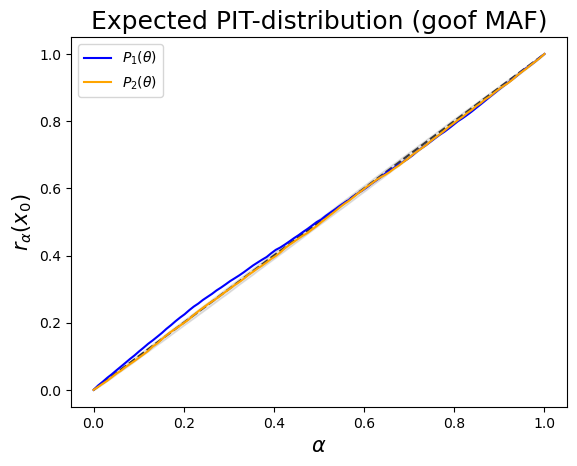

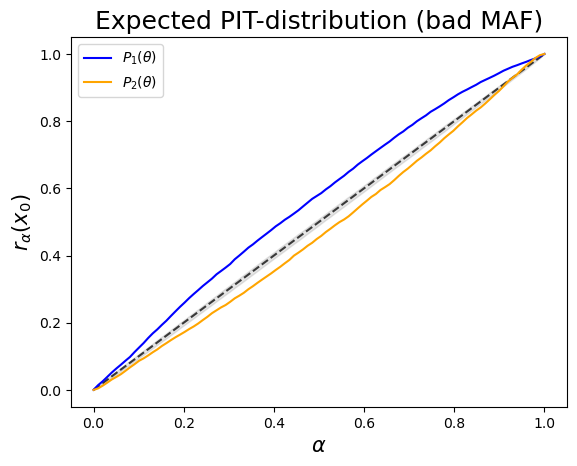

In [13]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators
theta_test, x_test = datasets['B_prime']['theta'], datasets['B_prime']['x']

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values_good = multi_cde_pit_values(
    theta_test, x_test, maf_good, 
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = multi_cde_pit_values(
    theta_test, first_dim_only(x_test), maf_bad, 
)

# PP-plot of expected PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]

# Good MAF
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good[0], flow_joint_pit_values_good[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["blue", "orange"],
    labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
    title=r"Expected PIT-distribution (goof MAF)",
    confidence_int = True,
)

# Bad MAF
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_bad[0], flow_joint_pit_values_bad[1]],
    alphas=np.linspace(0, 1, 100),
    colors=["blue", "orange"],
    labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
    title=r"Expected PIT-distribution (bad MAF)",
    confidence_int = True,
)


### Local Coverage
Estimate the local PIT values and the correlation coefficient via regression.

#### PP-plots

In [14]:
# TRAIN Local PIT regressors

from functools import partial
from valdiags.multi_local_test import multi_local_pit_regression
from sklearn.neural_network import MLPClassifier
DEFAULT_CLF = MLPClassifier(alpha=0, max_iter=25000)
ALPHAS = np.linspace(0,0.99,100)
REG_METHOD = partial(
    localPIT_regression_baseline, alphas = ALPHAS
)
x_train = datasets['B_prime']['x'][:,:,None]

if os.path.exists(PATH_EXPERIMENT+'clfs_trained_bad.pkl'):
    clfs_bad = torch.load(PATH_EXPERIMENT+'clfs_trained_bad.pkl')
else:
    _, clfs_bad = multi_local_pit_regression(dim=2,pit_values_train=flow_joint_pit_values_bad,x_train=x_train, reg_method=REG_METHOD, classifier=DEFAULT_CLF)
    torch.save(clfs_bad, PATH_EXPERIMENT+'clfs_trained_bad.pkl')
if os.path.exists(PATH_EXPERIMENT+'clfs_trained_good.pkl'):
    clfs_good = torch.load(PATH_EXPERIMENT+'clfs_trained_good.pkl')
else:
    _, clfs_good = multi_local_pit_regression(dim=2,pit_values_train=flow_joint_pit_values_good,x_train=x_train, reg_method=REG_METHOD, classifier=DEFAULT_CLF)
    torch.save(clfs_good, PATH_EXPERIMENT+'clfs_trained_good.pkl')

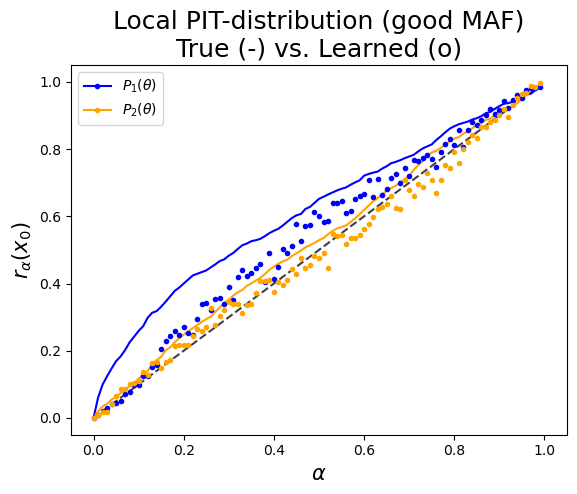

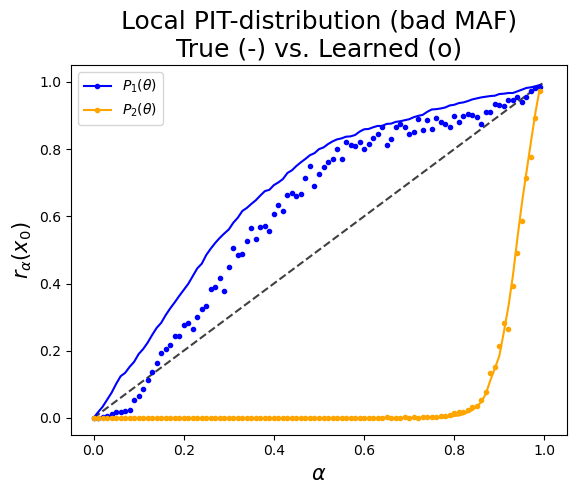

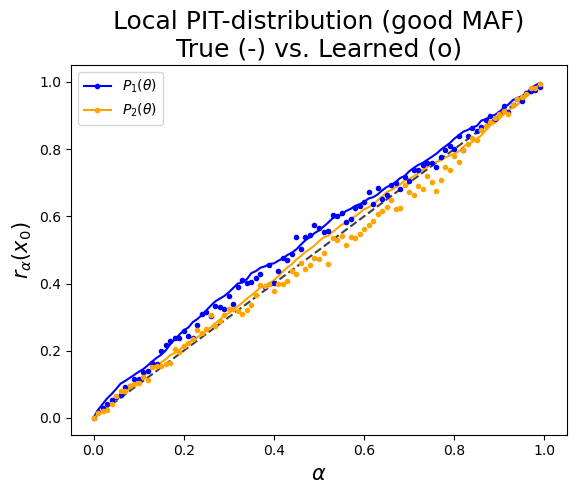

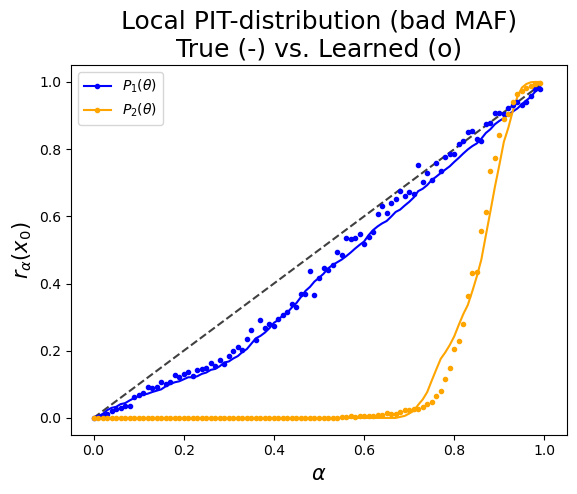

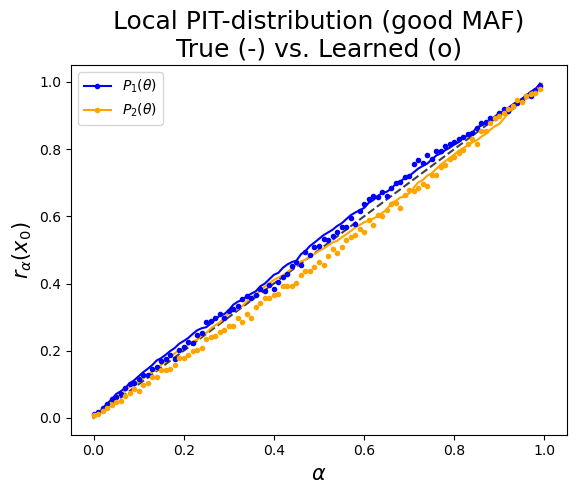

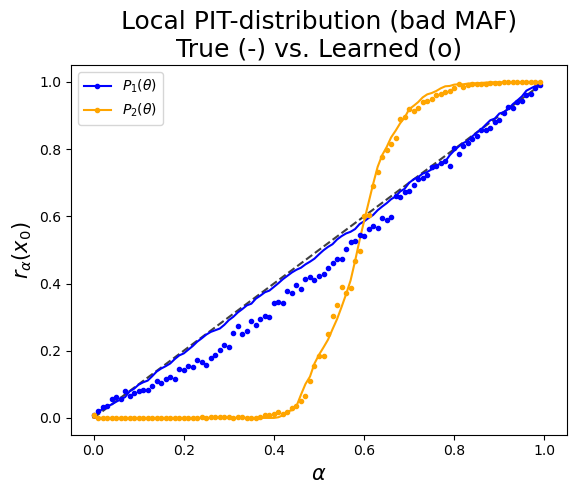

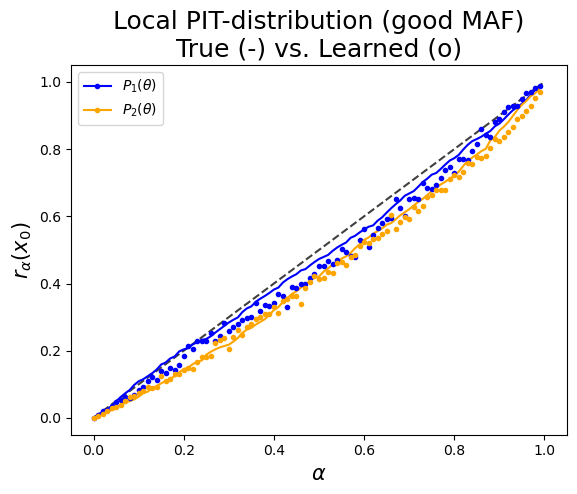

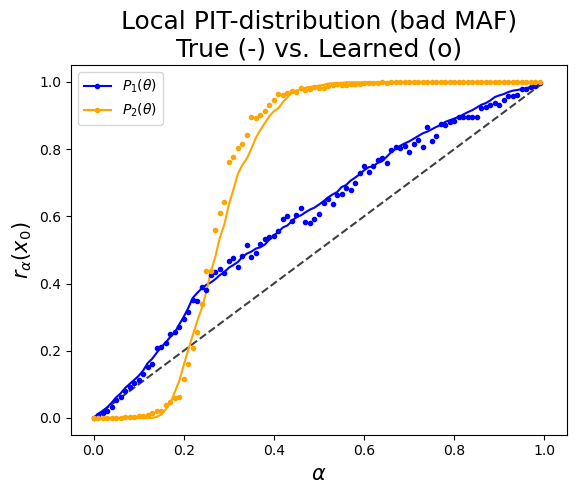

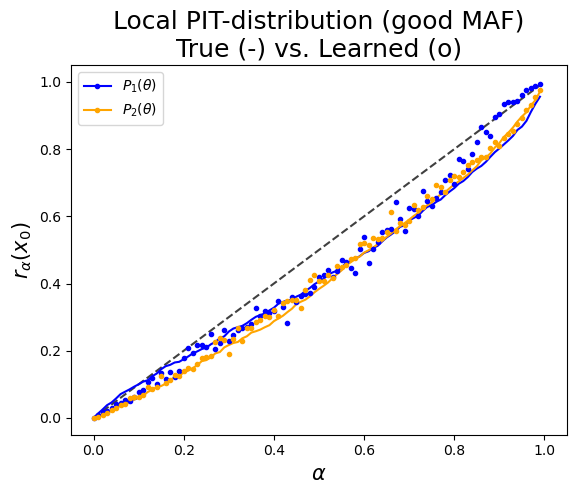

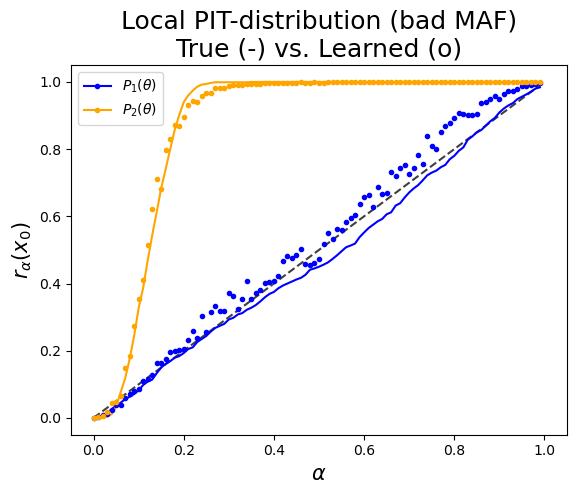

In [15]:
theta_true_list = [torch.FloatTensor([0, -8]), torch.FloatTensor([0, -6]), torch.FloatTensor([0, 0]), torch.FloatTensor([0, 6]), torch.FloatTensor([0, 8])]  # true parameters
x_obs_list = [simulator(theta_true) for theta_true in theta_true_list] # x_0 ~ simulator(theta_true)

for theta_true, x_obs in zip(theta_true_list, x_obs_list):
    # TRUE PIT-values of the flows [PIT(Theta_i, X_0, flow) = F_{Q|X_0}(Theta_i)
    true_posterior = data_gen.true_posterior(x_obs)
    theta_test_true = true_posterior.sample((1000,))  # samples of the true posterior
    # good maf
    flow_local_pit_values_good = multi_cde_pit_values(
        theta_test_true, x_obs.repeat((1000, 1)), maf_good, 
    )
    # bad maf
    flow_local_pit_values_bad = multi_cde_pit_values(
        theta_test_true,
        first_dim_only(x_obs.repeat((1000, 1))),
        maf_bad,
    )

    # Learned local PIT-values of the flows [PIT(Theta_i, X_0, flow) = F_{Q|X_0}(Theta_i)
    # good maf
    r_alpha_learned_good, _ = multi_local_pit_regression(
        dim=2,
        pit_values_train=flow_joint_pit_values_good,
        x_train=x_train,
        reg_method=REG_METHOD,
        classifier=DEFAULT_CLF,
        alphas_eval=ALPHAS,
        x_eval=x_obs[None, :, None],
        trained_clfs=clfs_good,
    )
    # bad maf
    r_alpha_learned_bad, _ = multi_local_pit_regression(
        dim=2,
        pit_values_train=flow_joint_pit_values_bad,
        x_train=x_train,
        reg_method=REG_METHOD,
        classifier=DEFAULT_CLF,
        alphas_eval=ALPHAS,
        x_eval=x_obs[None, :, None],
        trained_clfs=clfs_bad,
    )

    # PP-plot of local PIT-distribution for both flows
    # alpha-quantiles = [P_Theta|X_0(Z < alpha)]

    # Good MAF
    PP_plot_1D(
        PIT_values=[flow_local_pit_values_good[0], flow_local_pit_values_good[1]],
        # PIT_values=None,
        alphas=np.linspace(0, 0.99, 100),
        r_alpha_learned=[r_alpha_learned_good["dim_1"], r_alpha_learned_good["dim_2"]],
        colors=["blue", "orange"],
        colors_r_alpha=["blue", "orange"],
        labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
        title=r"Local PIT-distribution (good MAF)" "\n" "True (-) vs. Learned (o)",
    )

    # Bad MAF
    PP_plot_1D(
        PIT_values=[flow_local_pit_values_bad[0], flow_local_pit_values_bad[1]],
        # PIT_values=None,
        alphas=np.linspace(0, 0.99, 100),
        r_alpha_learned=[r_alpha_learned_bad["dim_1"], r_alpha_learned_bad["dim_2"]],
        colors=["blue", "orange"],
        colors_r_alpha=["blue", "orange"],
        labels=[r"$P_1(\theta)$", r"$P_2(\theta)$"],
        title=r"Local PIT-distribution (bad MAF)" "\n" "True (-) vs. Learned (o)",
    )


## Confidence Regions: HPD vs. WALDO

### High Posterior Region: Confidence sets computed directly with the learned posterior

In [34]:
# 2-dimensional grid of (grid_sample_size X grid_sample_size) points
grid_sample_size = 100
param_grid_1d = np.linspace(-10, 10, num=grid_sample_size)
param_grid = np.transpose([np.tile(param_grid_1d, len(param_grid_1d)), np.repeat(param_grid_1d, len(param_grid_1d))])
grid_sample_size = grid_sample_size**2

# observations we whish to evaluate the posterior in
observations = [
    x_obs,  # generated via simulator and theta_true = [1,1]
    torch.FloatTensor([1, 1]),  # for reference = theta_true
    torch.FloatTensor([0, 0]),  # for comparison
    torch.FloatTensor([-1, -1]),  # for comparison
]

In [35]:
# Compute High Posterior Regions
hpd_regions_good = []
hpd_regions_bad = []
actual_confidence_levels_good = []
actual_confidence_levels_bad = []
for i in tqdm(range(len(observations))):
    x = observations[i][None].repeat(grid_sample_size,1)
    current_confidence_level_good, credible_region_good, _ = hpd_region(
        posterior=maf_good,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=x,
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    current_confidence_level_bad, credible_region_bad, _ = hpd_region(
        posterior=maf_bad,
        prior=None,
        param_grid=torch.FloatTensor(param_grid.astype(np.float32)),
        x=first_dim_only(x),
        confidence_level=CONFIDENCE_LEVEL,
        n_p_stars=100_000,
        tol=0.01,
    )
    hpd_regions_good.append(credible_region_good)
    hpd_regions_bad.append(credible_region_bad)
    actual_confidence_levels_good.append(current_confidence_level_good)
    actual_confidence_levels_bad.append(current_confidence_level_bad)


100%|██████████| 4/4 [00:21<00:00,  5.47s/it]


## Calibrated Confidence Regions using WALDO

$\tau^{\text{Waldo}} = (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)^T \Sigma^{-1} (\mathbb{E}[\mathbf{\theta}|\mathbf{x}] - \theta_0)$

In [36]:
# Compute Waldo test statistics on data from joint distribution

# GOOD MAF
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_good = torch.load(filename)
else:
    posterior_stats_waldo_good = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_good.sample(
            N_SAMPLES_POSTERIOR, context=datasets["B_prime"]["x"][i][None]
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo_good.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_good = np.array(posterior_stats_waldo_good)
    torch.save(posterior_stats_waldo_good, filename)

# BAD MAF
filename = PATH_EXPERIMENT + "posterior_stats_waldo_bad_bigDataset.pkl"
if os.path.exists(filename):
    posterior_stats_waldo_bad = torch.load(filename)
else:
    posterior_stats_waldo_bad = []
    for i in tqdm(range(B_PRIME)):
        posterior_samples_qr = maf_bad.sample(
            N_SAMPLES_POSTERIOR,
            context=first_dim_only(datasets["B_prime"]["x"][i][None]),
        )[0]
        posterior_mean = torch.mean(posterior_samples_qr, dim=0)
        posterior_var = torch.cov(torch.transpose(posterior_samples_qr, 0, 1))
        waldo_stats_i = waldo_stats(
            posterior_mean, posterior_var, param=datasets["B_prime"]["theta"][i, :]
        )
        posterior_stats_waldo_bad.append(waldo_stats_i)
    del posterior_mean, posterior_var

    posterior_stats_waldo_bad = np.array(posterior_stats_waldo_bad)
    torch.save(posterior_stats_waldo_bad, filename)

In [40]:
# Train quantile regression for critical value prediction

# GOOD MAF
filename = PATH_EXPERIMENT + "waldo_qr_nns.pkl"
if os.path.exists(filename):
    waldo_qr_nns_good = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_good,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_good = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_good, "waldo_qr_nns.pkl")

# BAD MAF
filename = PATH_EXPERIMENT + "waldo_qr_nns_bad.pkl"
if os.path.exists(filename):
    waldo_qr_nns_bad = torch.load(filename)
else:
    learner_kwargs = {"epochs": 1000, "batch_size": 50}
    pytorch_kwargs = {"neur_shapes": (128, 128, 128)}
    qr_nn, predicted_cutoffs_nn = train_qr_algo(
        dim=2,
        alpha=CONFIDENCE_LEVEL,
        theta_mat=datasets["B_prime"]["theta"].numpy(),
        stats_mat=posterior_stats_waldo_bad,
        learner_kwargs=learner_kwargs,
        pytorch_kwargs=pytorch_kwargs,
        prediction_grid=param_grid,
        nn_dropout=0.0,
    )

    waldo_qr_nns_bad = {"qr_nn": qr_nn, "cutoffs_nn": predicted_cutoffs_nn}
    torch.save(waldo_qr_nns_bad, "waldo_qr_nns_bad.pkl")


In [41]:
# Compute calibrated confidence sets with waldo stats and critical values
confidence_sets_good = []
confidence_sets_bad = []
for i in tqdm(range(len(observations)), desc="Computing confidence sets"):
    # sample from learned posterior
    posterior_samples_obs_good = maf_good.sample(
        N_SAMPLES_POSTERIOR, context=observations[i][None]
    )[0]
    posterior_samples_obs_bad = maf_bad.sample(
        N_SAMPLES_POSTERIOR, context=first_dim_only(observations[i][None])
    )[0]
    confidence_sets_good.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_good,
            critical_values=waldo_qr_nns_good["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )
    confidence_sets_bad.append(
        waldo_confidence_region(
            posterior_samples=posterior_samples_obs_bad,
            critical_values=waldo_qr_nns_bad["cutoffs_nn"],
            param_grid=param_grid,
            grid_sample_size=grid_sample_size,
        )
    )



Computing confidence sets: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


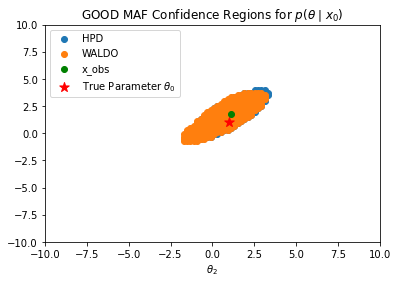

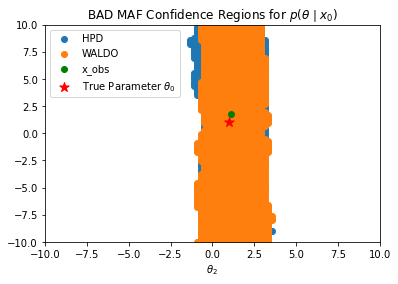

In [52]:
# Plot HPD vs WALDO Confidence Regions 

# GOOD MAF
plt.scatter(hpd_regions_good[0][:, 0], hpd_regions_good[0][:, 1], label='HPD')
plt.scatter(confidence_sets_good[0][:, 0], confidence_sets_good[0][:, 1], label='WALDO')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'GOOD MAF Confidence Regions for $p(\theta \mid x_0)$')
plt.show()

# BAD MAF
plt.scatter(hpd_regions_bad[0][:, 0], hpd_regions_bad[0][:, 1], label='HPD')
plt.scatter(confidence_sets_bad[0][:, 0], confidence_sets_bad[0][:, 1], label='WALDO')
plt.scatter(x_obs[0], x_obs[1], color="green", label="x_obs", zorder=3)
plt.scatter(
    theta_true[0],
    theta_true[1],
    marker="*",
    color="red",
    s=100,
    zorder=1,
    label=r"True Parameter $\theta_0$",
)
plt.xlabel(r"$\theta_1$")
plt.xlabel(r"$\theta_2$")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.legend()
plt.title(r'BAD MAF Confidence Regions for $p(\theta \mid x_0)$')
plt.show()


Both CRs are very non-informative for the bad NPE, it shows we first need to check the validity of the estimator before using it to construct confidence regions.